# L9: Evaluation Part II

Evaluate LLM responses where there isn't a single "right answer."

## Setup
#### Load the API key and relevant Python libaries.
In this course, we've provided some code that loads the OpenAI API key for you.

In [ ]:
import os
import openai
import sys
sys.path.append('../..')
import utils
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [ ]:
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=500):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, 
        max_tokens=max_tokens, 
    )
    return response.choices[0].message["content"]

### Run through the end-to-end system to answer the user query

These helper functions are running the chain of promopts that you saw in the earlier videos.

In [ ]:
customer_msg = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs or TV related products do you have?"""

products_by_category = utils.get_products_from_query(customer_msg)
category_and_product_list = utils.read_string_to_list(products_by_category)
product_info = utils.get_mentioned_product_info(category_and_product_list)
assistant_answer = utils.answer_user_msg(user_msg=customer_msg,
                                                   product_info=product_info)

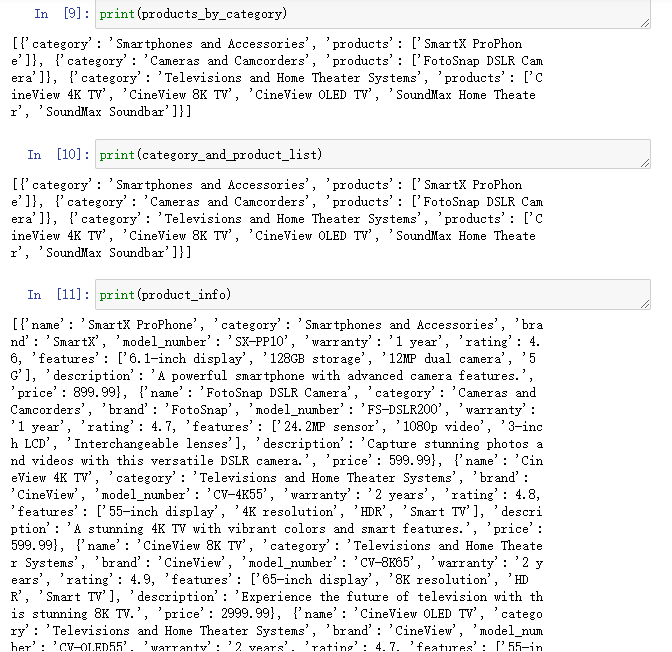

In [ ]:
print(assistant_answer) 

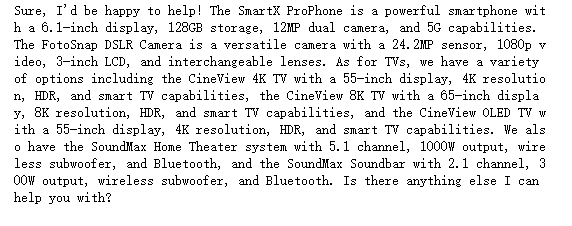

### Evaluate the LLM's answer to the user with a rubric, based on the extracted product information

In [ ]:
cust_prod_info = {
    'customer_msg': customer_msg,
    'context': product_info
}

In [ ]:
def eval_with_rubric(test_set, assistant_answer):

    cust_msg = test_set['customer_msg']
    context = test_set['context']
    completion = assistant_answer
    
    system_message = """\
    You are an assistant that evaluates how well the customer service agent \
    answers a user question by looking at the context that the customer service \
    agent is using to generate its response. 
    """

    user_message = f"""\
You are evaluating a submitted answer to a question based on the context \
that the agent uses to answer the question.
Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {cust_msg}
    ************
    [Context]: {context}
    ************
    [Submission]: {completion}
    ************
    [END DATA]

Compare the factual content of the submitted answer with the context. \
Ignore any differences in style, grammar, or punctuation.
Answer the following questions:
    - Is the Assistant response based only on the context provided? (Y or N)
    - Does the answer include information that is not provided in the context? (Y or N)
    - Is there any disagreement between the response and the context? (Y or N)
    - Count how many questions the user asked. (output a number)
    - For each question that the user asked, is there a corresponding answer to it?
      Question 1: (Y or N)
      Question 2: (Y or N)
      ...
      Question N: (Y or N)
    - Of the number of questions asked, how many of these questions were addressed by the answer? (output a number)
"""

    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': user_message}
    ]

    response = get_completion_from_messages(messages)
    return response

In [ ]:
evaluation_output = eval_with_rubric(cust_prod_info, assistant_answer)
print(evaluation_output)

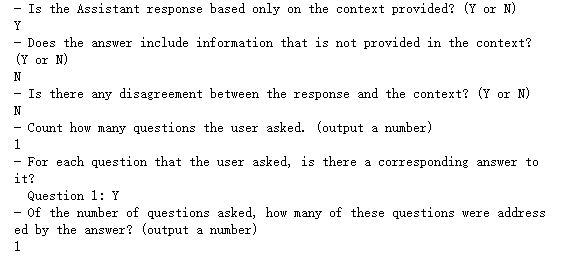

### Evaluate the LLM's answer to the user based on an "ideal" / "expert" (human generated) answer.

In [ ]:
test_set_ideal = {
    'customer_msg': """\
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs or TV related products do you have?""",
    'ideal_answer':"""\
Of course!  The SmartX ProPhone is a powerful \
smartphone with advanced camera features. \
For instance, it has a 12MP dual camera. \
Other features include 5G wireless and 128GB storage. \
It also has a 6.1-inch display.  The price is $899.99.

The FotoSnap DSLR Camera is great for \
capturing stunning photos and videos. \
Some features include 1080p video, \
3-inch LCD, a 24.2MP sensor, \
and interchangeable lenses. \
The price is 599.99.

For TVs and TV related products, we offer 3 TVs \


All TVs offer HDR and Smart TV.

The CineView 4K TV has vibrant colors and smart features. \
Some of these features include a 55-inch display, \
'4K resolution. It's priced at 599.

The CineView 8K TV is a stunning 8K TV. \
Some features include a 65-inch display and \
8K resolution.  It's priced at 2999.99

The CineView OLED TV lets you experience vibrant colors. \
Some features include a 55-inch display and 4K resolution. \
It's priced at 1499.99.

We also offer 2 home theater products, both which include bluetooth.\
The SoundMax Home Theater is a powerful home theater system for \
an immmersive audio experience.
Its features include 5.1 channel, 1000W output, and wireless subwoofer.
It's priced at 399.99.

The SoundMax Soundbar is a sleek and powerful soundbar.
It's features include 2.1 channel, 300W output, and wireless subwoofer.
It's priced at 199.99

Are there any questions additional you may have about these products \
that you mentioned here?
Or may do you have other questions I can help you with?
    """
}

### Check if the LLM's response agrees with or disagrees with the expert answer

This evaluation prompt is from the [OpenAI evals](https://github.com/openai/evals/blob/main/evals/registry/modelgraded/fact.yaml) project.

[BLEU score](https://en.wikipedia.org/wiki/BLEU): another way to evaluate whether two pieces of text are similar or not.

In [ ]:
def eval_vs_ideal(test_set, assistant_answer):

    cust_msg = test_set['customer_msg']
    ideal = test_set['ideal_answer']
    completion = assistant_answer
    
    system_message = """\
    You are an assistant that evaluates how well the customer service agent \
    answers a user question by comparing the response to the ideal (expert) response
    Output a single letter and nothing else. 
    """

    user_message = f"""\
You are comparing a submitted answer to an expert answer on a given question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {cust_msg}
    ************
    [Expert]: {ideal}
    ************
    [Submission]: {completion}
    ************
    [END DATA]

Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
    The submitted answer may either be a subset or superset of the expert answer, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
    (A) The submitted answer is a subset of the expert answer and is fully consistent with it.
    (B) The submitted answer is a superset of the expert answer and is fully consistent with it.
    (C) The submitted answer contains all the same details as the expert answer.
    (D) There is a disagreement between the submitted answer and the expert answer.
    (E) The answers differ, but these differences don't matter from the perspective of factuality.
  choice_strings: ABCDE
"""

    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': user_message}
    ]

    response = get_completion_from_messages(messages)
    return response

In [ ]:
print(assistant_answer)

In [ ]:
eval_vs_ideal(test_set_ideal, assistant_answer)

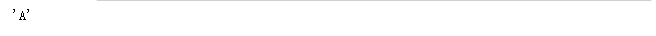

In [ ]:
assistant_answer_2 = "life is like a box of chocolates"

In [ ]:
eval_vs_ideal(test_set_ideal, assistant_answer_2)

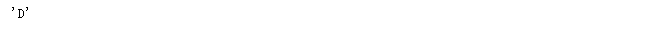